In [183]:
%matplotlib inline

In [282]:
import random
from typing import Dict, Literal, TypeAlias, Union
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np

In [17]:
random.seed(42)

In [124]:
# Testing two variants of the same function for computational efficiency
DNA_NUCLEOTIDES: TypeAlias = Literal["A", "T", "C", "G", "N"]
DNA_NUCLEOTIDE_STR: TypeAlias = Union[Literal["A", "T", "C", "G", "N", ""]]
RNA_NUCLEOTIDES: TypeAlias = Literal["A", "U", "C", "G", "N"]
RNA_NUCLEOTIDE_STR: TypeAlias = Union[Literal["A", "U", "C", "G", "N", ""]]

DNA_BASE_PAIRS: Dict[DNA_NUCLEOTIDES, DNA_NUCLEOTIDES] = {
    "A": "T",
    "T": "A",
    "C": "G",
    "G": "C",
    "N": "N"
}

RNA_BASE_PAIRS: Dict[RNA_NUCLEOTIDES, RNA_NUCLEOTIDES] = {
    "A": "U",
    "U": "A",
    "C": "G",
    "G": "C",
    "N": "N"
}


def naive(
    pat,
    ref
):
    """Find all the alignments use naive pattern matching of a pattern
    against a reference string

    Parameters
    ----------
    pat : str
        Pattern string
    ref : str
        Reference string

    Returns
    -------
    list[int]
        Alignment offsets

    >>> p, ten_as = "CCC", "A" * 10
    >>> t = ten_as + "CCC" + ten_as + "GGG" + ten_as
    >>> naive_with_rc(p, t)
    [10]
    """
    occurrences: list[int] = []
    for i in range(len(ref) - len(pat) + 1):  # loop over alignments
        match = True
        for j in range(len(pat)):  # loop over characters
            if ref[i + j] != pat[j]:  # compare characters
                match = False
                break
        if match:
            occurrences.append(i)  # all chars matched; record
    return occurrences


def reverse_complement(
    seq,
    *,
    rna=False
):
    """Get the reverse complement of a nucleotide sequence

    Parameters
    ----------
    seq : str
        Sequence of nucleotides
    rna : bool
        Is a RNA sequence (default=False)

    Returns
    -------
    str
        Reverse complement

    >>> reverse_complement("ATC")
    "GAT"
    >>> reverse_complement("UAGC", rna=True)
    "AUCG
    """
    complements = RNA_BASE_PAIRS if rna else DNA_BASE_PAIRS
    return "".join(reversed([complements[char] for char in seq]))


naive_forward = naive

def naive_with_rc(
    pat,
    ref,
    *,
    rna=False
):
    """Find all pattern and its reverse complement matches in a reference string

    Parameters
    ----------
    pat : str
        Pattern string
    ref : str
        Reference string
    rna : bool
        If pattern is RNA (default=False)

    Returns
    -------
    list[int]
        occurrences of the pattern

    >>> p, ten_as = "CCC", "A" * 10
    >>> t = ten_as + "CCC" + ten_as + "GGG" + ten_as
    >>> naive_with_rc(p, t)
    [10, 23]
    """
    occurrences: list[int] = []
    rc_pat = reverse_complement(pat, rna=rna)
    rc_is_palindrome = rc_pat == pat
    for i in range(len(ref) - len(pat) + 1):  # loop over alignments
        match = True
        # If RC is a palindrome (True), then rc_match is set to False
        # as there is no need to repeat the comparison
        rc_match = not rc_is_palindrome
        for j in range(len(pat)):  # loop over characters
            if match and ref[i + j] != pat[j]:
                match = False
            if rc_match and ref[i + j] != rc_pat[j]:
                rc_match = False
            if not match and not rc_match:
                break
        if match or rc_match:
            occurrences.append(i)  # all chars matched; record
    return occurrences


def read_genome(fasta):
    """Read a genome from a FASTA file

    Parameters
    ----------
    fasta : str
        FASTA filename

    Returns
    -------
    str
        Single strand genome
    """
    genome: DNA_NUCLEOTIDE_STR = ""
    with open(fasta, 'r') as f:
        for line in f:
            # ignore header line with genome information
            if not line[0] == '>':
                genome += line.rstrip()
    return genome


def read_fastq(fastq):
    """Get the reads and associated PHRED qualities from a FASTQ file

    Parameters
    ----------
    fastq : str
        FASTQ file with reads

    Returns
    -------
    tuple[list[str], list[str]]
        Matching lists of sequences and corresponding PHRED quality
    """
    sequences: list[DNA_NUCLEOTIDE_STR] = []
    qualities: list[str] = []
    with open(fastq, 'r') as fh:
        while True:
            try:
                fh.readline()  # skip name line
                seq = fh.readline().rstrip()  # read base sequence
                fh.readline()  # skip placeholder line
                qual = fh.readline().rstrip() # base quality line
                if len(seq) == 0:
                    break
                sequences.append(seq)
                qualities.append(qual)
            except:
                continue
    return sequences, qualities

In [105]:
"""Some converters between PHRED and Q=-10*log(p) measurements"""
def phred_2_quality(phred: str) -> int:
    return ord(phred) - 33

def quality_2_phred(quality: float) -> str:
    return str(quality + 33)

phred_2_quality("I")

40

In [106]:
!wget https://d28rh4a8wq0iu5.cloudfront.net/ads1/data/lambda_virus.fa
!mkdir -p week1hw
!mv lambda_virus.fa week1hw

--2022-11-24 15:11:35--  https://d28rh4a8wq0iu5.cloudfront.net/ads1/data/lambda_virus.fa
Resolving d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)... 108.156.200.29, 108.156.200.25, 108.156.200.204, ...
Connecting to d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)|108.156.200.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49270 (48K) [application/octet-stream]
Saving to: ‘lambda_virus.fa’

lambda_virus.fa     100%[===================>]  48.12K  --.-KB/s    in 0.008s  

2022-11-24 15:11:35 (5.60 MB/s) - ‘lambda_virus.fa’ saved [49270/49270]



In [107]:
!wget http://d396qusza40orc.cloudfront.net/ads1/data/phix.fa
!mkdir -p week1hw
!mv phix.fa week1hw

--2022-11-24 15:11:36--  http://d396qusza40orc.cloudfront.net/ads1/data/phix.fa
Resolving d396qusza40orc.cloudfront.net (d396qusza40orc.cloudfront.net)... 108.156.200.176, 108.156.200.24, 108.156.200.181, ...
Connecting to d396qusza40orc.cloudfront.net (d396qusza40orc.cloudfront.net)|108.156.200.176|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5528 (5.4K) [application/octet-stream]
Saving to: ‘phix.fa’

phix.fa             100%[===================>]   5.40K  --.-KB/s    in 0s      

2022-11-24 15:11:36 (71.2 MB/s) - ‘phix.fa’ saved [5528/5528]



In [108]:
p = 'CCC'
ten_as = 'AAAAAAAAAA'
five_gs = 'G' * 5
t = ten_as + 'CCC' + ten_as + 'GGG' + ten_as
test_occurrences = naive_with_rc(p, t)
print(test_occurrences)

[10, 23]


In [109]:
p = 'CGCG'
t = ten_as + 'CGCG' + ten_as + 'CGCG' + ten_as
test_occurrences = naive_with_rc(p, t)
print(test_occurrences)


[10, 24]


In [110]:
p = 'CGCG'
t = five_gs + 'CGCG' + ten_as + 'CCCC' + five_gs
test_occurrences = naive_with_rc(p, t)
print(test_occurrences)


[5]


In [125]:
phix_genome = read_genome(str(Path("week1hw/phix.fa")))
lambda_genome = read_genome(str(Path("week1hw/lambda_virus.fa")))

In [112]:
phix_genome[0:70]

'GAGTTTTATCGCTTCCATGACGCAGAAGTTAACACTTTCGGATATTTCTGATGAGTCGAAAAATTATCTT'

In [120]:
test_occurrences = naive_with_rc('ATTA', phix_genome)
test_occurrences[0:10]

[62, 82, 103, 245, 341, 373, 440, 639, 707, 710]

In [121]:
print('offset of leftmost occurrence: %d' % min(test_occurrences))

offset of leftmost occurrence: 62


In [122]:
print('# occurrences: %d' % len(test_occurrences))

# occurrences: 60


# Quiz

## Q1 How many times does AGGT or its reverse complement (ACCT) occur in the lambda virus genome?  E.g. if AGGT occurs 10 times and ACCT occurs 12 times, you should report 22.

In [294]:
print('AGGT # occurrences: %d' % len(naive_with_rc("AGGT", lambda_genome)))

AGGT # occurrences: 306


## Q2: How many times does TTAA or its reverse complement occur in the lambda virus genome?

In [128]:
print('TTAA # occurrences: %d' % len(naive_with_rc("TTAA", lambda_genome)))

TTAA # occurrences: 195


## Q3: What is the offset of the leftmost occurrence of ACTAAGT or its reverse complement in the Lambda virus genome?  E.g. if the leftmost occurrence of ACTAAGT is at offset 40 (0-based) and the leftmost occurrence of its reverse complement ACTTAGT is at offset 29, then report 29.

In [131]:
print('ACTAAGT # left-most offset: %d' % min(naive_with_rc("ACTAAGT", lambda_genome)))

ACTAAGT # left-most offset: 26028


## Q4: What is the offset of the leftmost occurrence of AGTCGA or its reverse complement in the Lambda virus genome?

In [132]:
print('AGTCGA # left-most offset: %d' % min(naive_with_rc("AGTCGA", lambda_genome)))

AGTCGA # left-most offset: 450


## Q5 and Q6 Preamble

As we will discuss, sometimes we would like to find approximate matches for P in T. That is, we want to find occurrences with one or more differences.

For Questions 5 and 6, make a new version of the naive function called naive_2mm that allows up to 2 mismatches per occurrence. Unlike for the previous questions, do not consider the reverse complement here.  We're looking for approximate matches for P itself, not its reverse complement.

￼

For example, ACTTTAACTTTA occurs twice in ACTTACTTGATAAAGT, once at offset 0 with 2 mismatches, and once at offset 4 with 1 mismatch. So naive_2mm('ACTTTA','ACTTACTTGATAAAGT') should return the list [0, 4]

In [138]:
def naive_with_mm(
    pat,
    ref,
    mm,
):
    """Find all pattern matches in a reference string allowing for mismatches

    Parameters
    ----------
    pat : str
        Pattern string
    ref : str
        Reference string
    mm : int
        Number of allowed mismatches

    Returns
    -------
    list[int]
        occurrences of the pattern

    """
    occurrences: list[int] = []
    for i in range(len(ref) - len(pat) + 1):  # loop over alignments
        match = True
        mm_counter = 0
        for j in range(len(pat)):  # loop over characters
            if match and ref[i + j] != pat[j]:
                mm_counter += 1
            if mm_counter > mm:
                match = False
                break
        if match:
            occurrences.append(i)  # all chars matched; record
    return occurrences


def naive_2mm(
    pat,
    ref,
):
    """Naive matching allowing for 2 mismatches"""
    return naive_with_mm(pat, ref, mm=2)


print(naive_2mm("ACTTTA","ACTTACTTGATAAAGT"))
p = 'CTGT'
ten_as = 'AAAAAAAAAA'
t = ten_as + 'CTGT' + ten_as + 'CTTT' + ten_as + 'CGGG' + ten_as
print(naive_2mm(p, t))
occurrences = naive_2mm("GATTACA", phix_genome)
print('offset of leftmost occurrence: %d' % min(occurrences))
print('# occurrences: %d' % len(occurrences))

[0, 4]
[10, 24, 38]
offset of leftmost occurrence: 10
# occurrences: 79


## Q5: How many times does TTCAAGCC occur in the Lambda virus genome when allowing up to 2 mismatches?

In [142]:
print('TTCAAGCC # occurrences: %d' % len(naive_2mm("TTCAAGCC", lambda_genome)))

TTCAAGCC # occurrences: 191


## Q6: What is the offset of the leftmost occurrence of AGGAGGTT in the Lambda virus genome when allowing up to 2 mismatches?

In [143]:
print('AGGAGGTT # left-most offset: %d' % min(naive_2mm("AGGAGGTT", lambda_genome)))

AGGAGGTT # left-most offset: 49


## Q7

Finally, download and parse the provided FASTQ file containing real DNA sequencing reads derived from a human:

 https://d28rh4a8wq0iu5.cloudfront.net/ads1/data/ERR037900_1.first1000.fastq

Note that the file has many reads in it and you should examine all of them together when answering this question.  The reads are taken from this study:

Ajay, S. S., Parker, S. C., Abaan, H. O., Fajardo, K. V. F., & Margulies, E. H. (2011). Accurate

and comprehensive sequencing of personal genomes. Genome research, 21(9), 1498-1505.

This dataset has something wrong with it; one of the sequencing cycles is poor quality.

Report which sequencing cycle has the problem.  Remember that a sequencing cycle corresponds to a particular offset in all the reads. For example, if the leftmost read position seems to have a problem consistently across reads, report 0. If the fourth position from the left has the problem, report 3. Do whatever analysis you think is needed to identify the bad cycle. It might help to review the "Analyzing reads by position" video.

In [144]:
!wget https://d28rh4a8wq0iu5.cloudfront.net/ads1/data/ERR037900_1.first1000.fastq
!mkdir -p week1hw
!mv ERR037900_1.first1000.fastq week1hw/

--2022-11-25 11:59:38--  https://d28rh4a8wq0iu5.cloudfront.net/ads1/data/ERR037900_1.first1000.fastq
Resolving d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)... 108.156.200.204, 108.156.200.104, 108.156.200.29, ...
Connecting to d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)|108.156.200.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 241626 (236K) [application/octet-stream]
Saving to: ‘ERR037900_1.first1000.fastq’

ERR037900_1.first10 100%[===================>] 235.96K  --.-KB/s    in 0.1s    

2022-11-25 11:59:39 (1.83 MB/s) - ‘ERR037900_1.first1000.fastq’ saved [241626/241626]



In [145]:
# The FASTQ file has 4000 reads and each read is of length 100.
sequences, qualities = read_fastq(str(Path("week1hw/ERR037900_1.first1000.fastq")))

My approach to this problem is to iterate over cycle offsets 0, 1, 2, ... and
run a counter over each of the quality at that offset.

If something goes dramatically wrong at a single cycle, the counters should indicate that.

In [240]:
# Design a dictionary of counters
# key is offset, value is counter dict for each quality key Q=-10*log(p)
offset_counters: dict[int, dict[int, int]] = {}

for offset in range(len(qualities[0])):
    qual_at_offset: list[int] = [
        phred_2_quality(read_qual[offset])
        for read_qual in qualities
    ]
    counter = Counter(qual_at_offset)
    offset_counters[offset] = dict(counter)


In [278]:
# Plot the bar/histogram of each cycle quality
def plot_quality_against_cycle(
    start_offset,
    end_offset
):
    fig, axes = plt.subplots(1, end_offset - start_offset + 1)

    for enum_index, offset in enumerate(range(start_offset, end_offset+1)):
        ax = axes[enum_index]
        ax.bar(
            list(offset_counters[offset].keys()),
            list(offset_counters[offset].values()),
            label="%d" % offset,
            log=True
        )
        ax.legend()


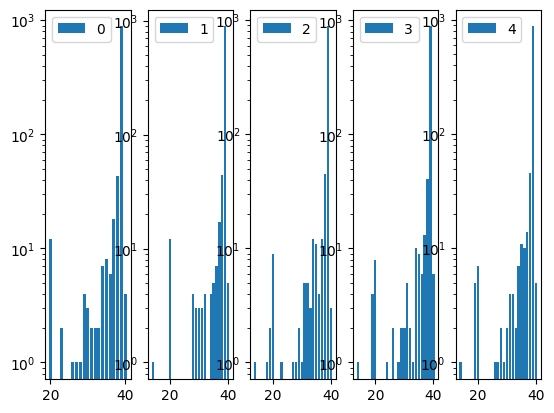

In [279]:
plot_quality_against_cycle(0, 4)

The first 5 cycles are demonstrate that the vast majority of predictions
have high confidence/quality. How does the quality change about half through the
set? Note from above that the reads are 100 in length, so the middle is about 50.


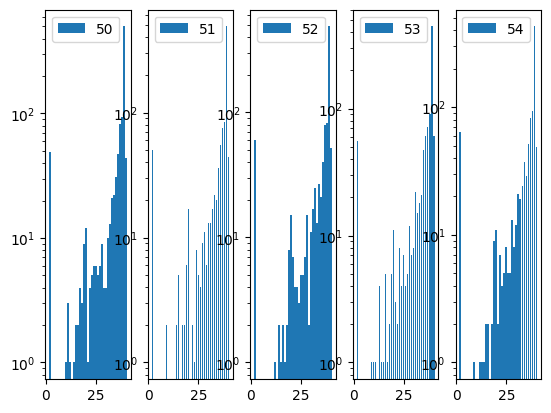

In [280]:
plot_quality_against_cycle(50, 54)

Notice that the quality peak close to 40 is declining and lower values have higher counter. This is expected.

Jumping to the 67-th cycle (66 offset), we see that bar plots change in behavior.

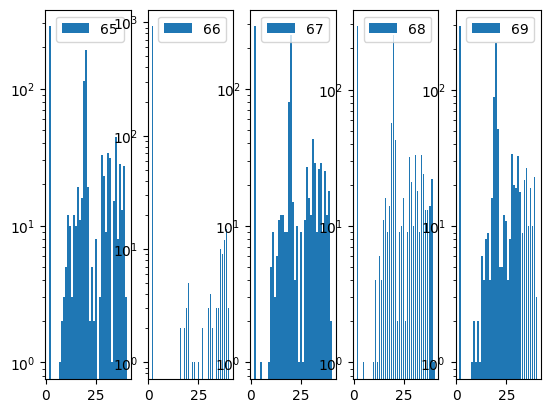

In [281]:
plot_quality_against_cycle(65, 69)

Maybe a summary plot will make this clearer.

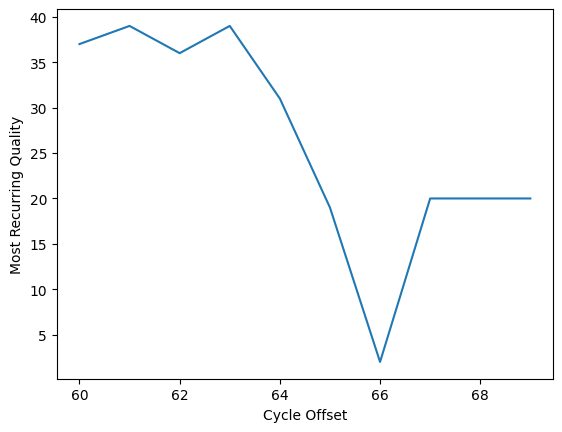

In [293]:
fig, ax = plt.subplots()
ax: plt.Axes
offsets: list[int] = []
max_quality: list[int] = []

for offset in sorted(offset_counters.keys()):
    counter_dict = offset_counters[offset]
    argmax = np.argmax(counter_dict.values())
    offsets.append(offset)
    max_quality.append(list(counter_dict.keys())[argmax])

ax.plot(
    offsets[60:70],
    max_quality[60:70]
)

ax.set_xlabel("Cycle Offset")
ax.set_ylabel("Most Recurring Quality")
plt.show(fig)

Indeed, the 67-th cycle has a significant quality decline